## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = "/content/drive/MyDrive/Machine Learning/"
import sys
sys.path.append(root)

### Required

In [4]:
from close.train_tuning import Model, LogisticRegression
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis

is_binary = False

In [5]:
model_type = "stacked_all"
base_models = [
    "cat-{'learning_rate'_ 0.1, 'max_depth'_ 10, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    "lgb-{'colsample_bytree'_ 1.0, 'learning_rate'_ 0.1, 'max_depth'_ 5, 'n_estimators'_ 200, 'subsample'_ 1.0}.pkl",
    "rf-best_model_33.pkl",
    "xgb-best-model-33.pkl",
    "knn-k24.pkl",
    "nn-k24.pkl"
]

## Loading Data

In [6]:
import pickle
import pandas as pd

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]

with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


In [7]:
X_train.columns

Index(['mean_iat', 'std_iat', 'median_iat', 'q25_iat', 'q75_iat', 'ratio_out',
       'switch_count', 'duration', 'n_packets', 'burst_count', 'burst_mean',
       'burst_std', 'burst_max', 'burst_ratio_in', 'num_in', 'num_out',
       'frac_in', 'in_first30', 'out_first30', 'mean_iat_first30',
       'std_iat_first30', 'median_iat_first30', 'q25_iat_first30',
       'q75_iat_first30', 'ratio_out_first30', 'switch_count_first30',
       'duration_first30', 'burst_count_first30', 'burst_mean_first30',
       'burst_std_first30', 'burst_max_first30', 'burst_ratio_in_first30',
       'frac_in_first30'],
      dtype='object')

## Model

### Model Loading

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

model = Model(is_binary=is_binary)
# base model
estimators = []
print("[Load base models]")
for model_pkl in base_models:
  model.load_model(f"{root}close/models/{model_pkl}")
  model_nm = model_pkl.split("-")[0]
  try:
    features = model._model.feature_names_in_
  except:
    features = model._model.feature_names_
  print(f"- {model_nm}: {len(features)} features")
  transformer = ColumnTransformer([
      ('selector', 'passthrough', features)
  ])
  pipeline = Pipeline([
    ('preprocessor', transformer),
    ('classifier', model._model)
  ])
  estimators.append((model_nm, pipeline))
# meta model
print("\n[Load meta model]")
meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)

[Load base models]
- cat: 33 features
- lgb: 33 features
- rf: 33 features


/usr/lib/python3.12/pickle.py:1760: UserWarning: [06:01:35] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


- xgb: 33 features
- knn: 24 features
- nn: 24 features

[Load meta model]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
estimators

[('cat',
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('selector', 'passthrough',
                                                    ['burst_max_first30',
                                                     'burst_count', 'ratio_out',
                                                     'num_in', 'duration',
                                                     'burst_std_first30',
                                                     'burst_count_first30',
                                                     'out_first30',
                                                     'burst_ratio_in',
                                                     'burst_mean', 'frac_in',
                                                     'burst_ratio_in_first30',
                                                     'n_packets', 'std_iat',
                                                     'burst_mean_first30',
                                                 

### Stacking

In [10]:
from sklearn.ensemble import StackingClassifier

stacked_model = StackingClassifier(estimators=estimators, final_estimator=meta_model)
stacked_model.fit(X_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochasti

StackingClassifier(estimators=[('cat',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('selector',
                                                                                  'passthrough',
                                                                                  ['burst_max_first30',
                                                                                   'burst_count',
                                                                                   'ratio_out',
                                                                                   'num_in',
                                                                                   'duration',
                                                                                   'burst_std_first30',
                                                                                   'burst_count_first30',
                                                                                   'out_first30',
                                                                                   'burst_ratio_in',
                                                                                   'burst_mean',
                                                                                   'frac_in',
                                                                                   'burst_ratio_in_first30',
                                                                                   'n_packets',
                                                                                   'std_iat',
                                                                                   'burst_mean_...
       'switch_count_first30', 'burst_count', 'switch_count', 'num_in',
       'burst_ratio_in', 'burst_ratio_in_first30', 'std_iat', 'n_packets',
       'out_first30', 'ratio_out_first30', 'burst_max', 'frac_in_first30',
       'in_first30', 'mean_iat'], dtype=object))])),
                                                ('classifier',
                                                 MLPClassifier(hidden_layer_sizes=(128,
                                                                                   64),
                                                               max_iter=300,
                                                               random_state=42))]))],
                   final_estimator=LogisticRegression())

### Evaluation

In [11]:
import numpy as np

In [12]:
import numpy as np

# 클래스 개수 및 이름 정의 (실제 라벨 값 기준)
classes = np.unique(y_train)
n_classes = len(classes)
class_names = [str(c) for c in classes]

# y는 1D numpy array로 통일
y = np.array(y_val)

# 예측값
y_pred = stacked_model.predict(X_val)

# 확률 예측: 멀티클래스면 shape = [n_samples, n_classes]
# 이진 분류처럼 [:, 1]로 한 클래스만 자르지 말고 전체를 유지
y_prob = stacked_model.predict_proba(X_val)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ut

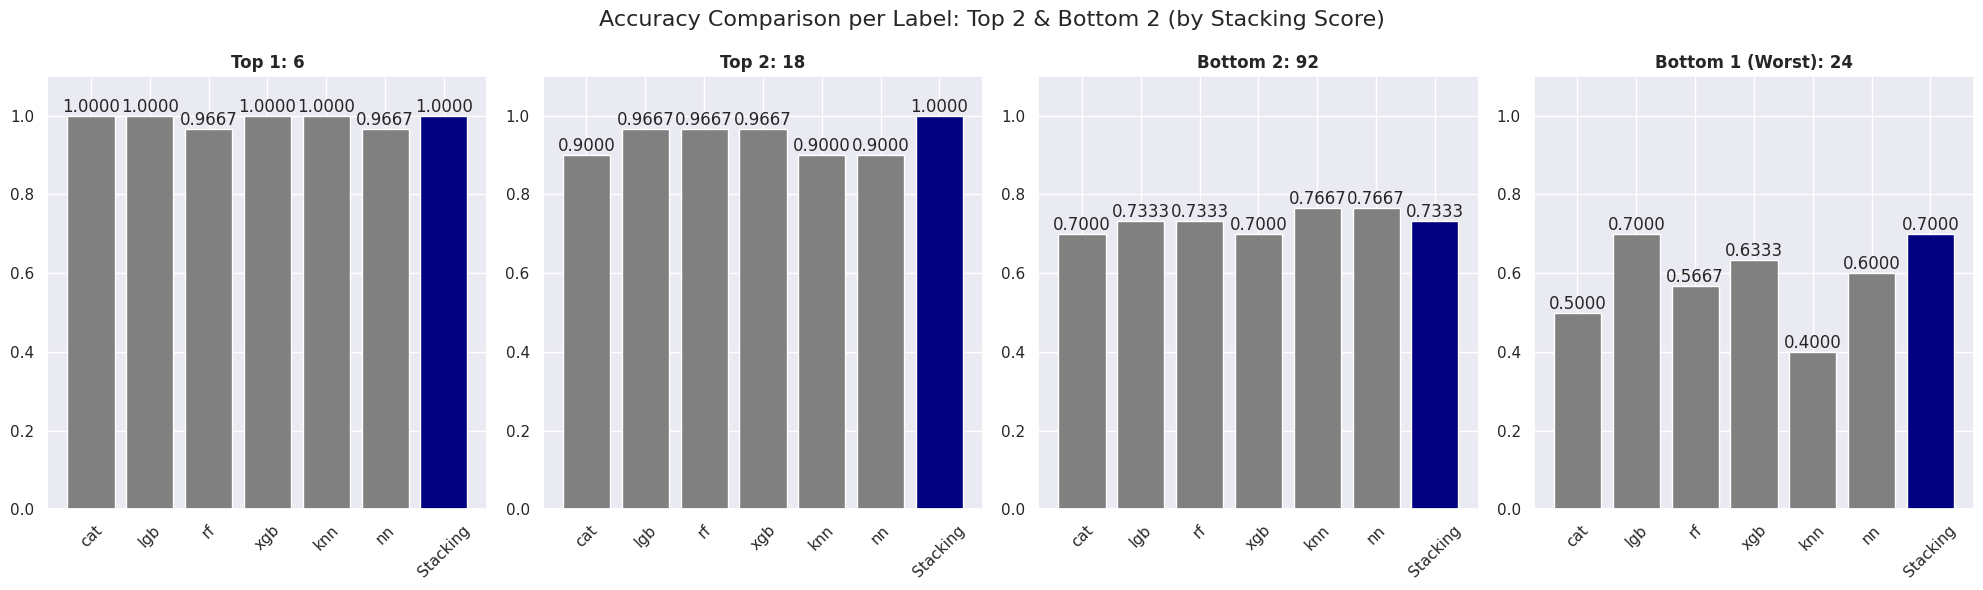

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# y를 1D numpy array로 통일
y = np.array(y_val)
y_pred = stacked_model.predict(X_val)

# 각 라벨별 Accuracy 계산 및 저장
# label_accuracies 구조: { '0': {'rf': 0.85, 'xgb': 0.88, 'Stacking': 0.90}, ... }
label_accuracies = {}

for i in range(n_classes):
    label_name = class_names[i]   # 예: "0", "1", "2", ...
    cls = i                       # 실제 라벨 값 (0,1,2,... 라고 가정)
    label_scores = {}

    # 이 클래스에 해당하는 샘플들만 뽑는 마스크
    mask = (y == cls)

    # 혹시 해당 클래스 샘플이 하나도 없으면 건너뛴다
    if mask.sum() == 0:
        continue

    # 1. Base Model의 Accuracy 계산 (이 클래스에 해당하는 샘플에서만)
    for name, model in zip(stacked_model.named_estimators_.keys(),
                           stacked_model.estimators_):
        y_pred_base_all = model.predict(X_val)   # shape: (n_samples,)
        y_true_lbl = y[mask]                    # 이 클래스에 해당하는 정답들
        y_pred_lbl = y_pred_base_all[mask]      # base 모델 예측 중 해당 클래스 샘플
        label_scores[name] = accuracy_score(y_true_lbl, y_pred_lbl)

    # 2. Stacking Model의 Accuracy 계산 (이 클래스에 해당하는 샘플에서만)
    y_true_lbl = y[mask]
    y_pred_stack_lbl = y_pred[mask]
    label_scores['Stacking'] = accuracy_score(y_true_lbl, y_pred_stack_lbl)

    label_accuracies[label_name] = label_scores

# Stacking 기준으로 label을 정렬하고, Top 2 / Bottom 2를 선택
sorted_labels = sorted(
    label_accuracies.items(),
    key=lambda x: x[1]['Stacking'],
    reverse=True
)

# label이 4개 이상이라고 가정 (적으면 그만큼만 사용)
top_2 = sorted_labels[:2]
bottom_2 = sorted_labels[-2:] if len(sorted_labels) >= 4 else sorted_labels[-2:]
selected_labels = top_2 + bottom_2

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Accuracy Comparison per Label: Top 2 & Bottom 2 (by Stacking Score)', fontsize=16)

for idx, (label, scores) in enumerate(selected_labels):
    ax = axes[idx]
    names = list(scores.keys())    # base 모델들 + 'Stacking'
    values = list(scores.values())
    colors = ['gray'] * (len(names) - 1) + ['navy']  # 마지막 'Stacking'만 진하게

    bars = ax.bar(names, values, color=colors)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, height,
                f'{height:.4f}', ha='center', va='bottom')

    if idx < 2:
        rank_text = f"Top {idx+1}"
    else:
        rank_text = f"Bottom {idx-1}"
        if idx == 2: rank_text = "Bottom 2"
        if idx == 3: rank_text = "Bottom 1 (Worst)"

    ax.set_title(f'{rank_text}: {label}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1.1)
    ax.set_xticklabels(names, rotation=45)

plt.tight_layout()
plt.show()


1. Confusion Matrix



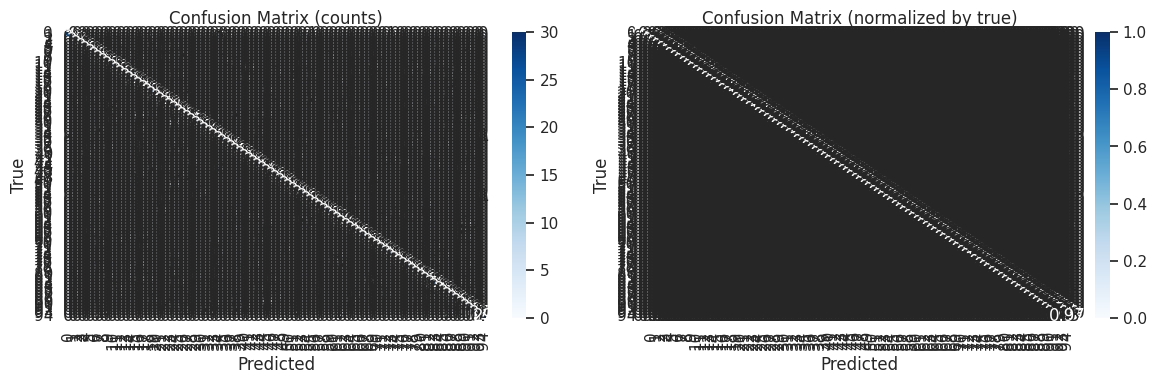

<Figure size 640x480 with 0 Axes>

In [14]:
cm = show_confusion_matrix(y, y_pred, class_names, model_type)

2. Per-class Accuracy



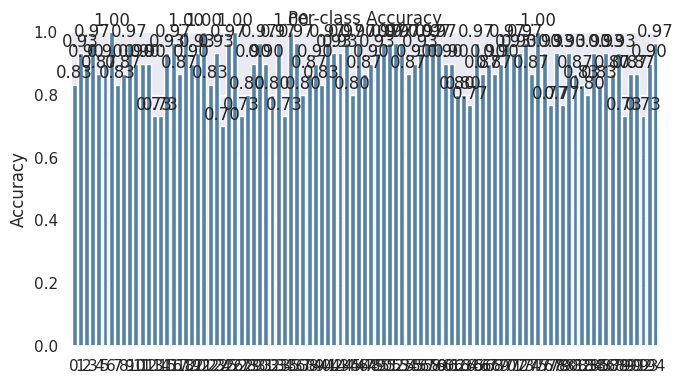

<Figure size 640x480 with 0 Axes>

In [15]:
per_class_accuracy(cm, class_names, model_type)

In [16]:
overall_metrics(y, y_pred, y_prob, n_classes)

3. Overall Metrics

- Accuracy: 0.8937
- Macro F1: 0.8937 (macro P=0.8972, macro R=0.8937)
- Weighted F1: 0.8937 (weighted P=0.8972, weighted R=0.8937)
- Log Loss: 0.4728


In [17]:
top_k_accuracy(y, y_prob, n_classes)

4. Top k Accuracy

- Top-1 accuracy: 0.8937
- Top-3 accuracy: 0.9502
- Top-5 accuracy: 0.9600


5. Confidence Analysis



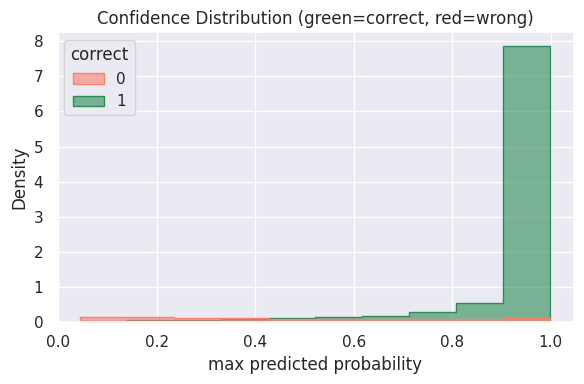

<Figure size 640x480 with 0 Axes>

In [18]:
confidence_analysis(y, y_pred, y_prob, model_type)

### Save Model

In [19]:
import joblib

joblib.dump(stacked_model, f"{root}/open/models/{model_type}")

['/content/drive/MyDrive/Machine Learning//open/models/stacked_all']